# Getting started

Here we will briefly demonstrate loading in ellipsometry datasets, creating a model and optimising that model to the dataset. For a more detailed description of model creation, please see the [getting started](https://refnx.readthedocs.io/en/latest/getting_started.html) tutorial on *refnx*.

## Fitting an ellipsometry dataset

We begin by importing all of the relevant packages.

In [6]:
import os
from os.path import join as pjoin
import numpy as np
import matplotlib.pyplot as plt
import scipy

import refnx
from refnx.analysis import CurveFitter
from refnx.reflect import Slab

import refellips
from refellips.dataSE import DataSE, open_EP4file
from refellips.reflect_modelSE import ReflectModelSE
from refellips.objectiveSE import ObjectiveSE
from refellips.structureSE import RI

For reproducibility, it is important to note the versions of software that you're using

In [7]:
print(f"refellips: {refellips.version.version}\n"
      f"refnx: {refnx.version.version}\n"
      f"scipy: {scipy.version.version}\n"
      f"numpy: {np.version.version}")

refellips: 0.0.0.dev0+fbffa7c
refnx: 0.1.27.dev0+978f997
scipy: 1.8.0
numpy: 1.21.4


### Loading a dataset

*refellips* has the capability of loading data directly from output files of both Accurion EP3 and EP4 ellipsometers, as well as Horiba ellipsometers using `open_EP4file` and `open_HORIBAfile` respectively.

Alternatively, other datasets can be imported using `DataSE`. The file must be formatted to contain four columns: wavelengnth, angle of incidence, psi and delta.

In [8]:
pth = os.path.dirname(refellips.__file__)
dname = 'testData1_11nm_PNIPAM_on_Si_EP4.dat'
file_path = pjoin(pth, '../', 'demos', dname)

We will now use `DataSE` to import our dataset.

In [9]:
data = DataSE(data=file_path)

### Creating a model for our interface

As with *refnx*, `Component` objects are assembled into a `Structure` object which describe the interface. The simplest of these `Component` objects is a `Slab`, which is what we will use here.

We begin by loading in dispersion curves which describe the refractive index for each layer within our `Structure` (i.e., for each `Component`). *refellips* offers multiple ways to prescribe the refractive index of a layer. Here we will load in dispersion curves (downloaded as a .csv file from [refractiveindex.info](https://refractiveindex.info/). When providing a dispersion curve, files must contain at least two columns, assumed to be wavelength (in microns) and refractive index. If three columns are provided the third is loaded as the extinction coefficient.

Alternatively, users can simply provide the Cauchy parameters ($a$, $b$, $c$) for the material of interest via `RI(A = a, B = , b, C = c)` or for single wavelength measurements the refractive index ($n$) can be provided via `RI(value = n)`.

In [30]:
si     = RI(pjoin(pth, 'materials/silicon.csv'))
sio2   = RI(pjoin(pth, 'materials/silica.csv'))
PNIPAM = RI(pjoin(pth, 'materials/pnipam.csv'))
air    = RI(pjoin(pth, 'materials/air.csv'))

Now we have defined the refractive indices of our layers, we can create a `Slab` object for each interfacial layer.

In [32]:
# this is a 20 Angstrom layer
silica_layer = sio2(20)

polymer_layer = PNIPAM(200)

Each `Slab` has an associated thickness (as defined above), roughness, and volume fraction of solvent. As this is a dry film we will leave vfsolv as 0.

In [33]:
silica_layer.name = 'Silica'
silica_layer.thick.setp(vary=True, bounds=(1, 30))
silica_layer.vfsolv.setp(vary=False, value=0)

polymer_layer.name = 'PNIPAM'
polymer_layer.thick.setp(vary=True, bounds=(100, 500))
polymer_layer.vfsolv.setp(vary=False, value=0)

We now create the `Structure` by assembling the `Component` objects. Our structure is defined from top to bottom.

In [34]:
structure = air(np.inf) | polymer_layer | silica_layer | si(np.inf)

Finally, we can create our model. A wavelength must be provided here, however, if your ellipsometry dataset contains a wavelength that will be automatically used. We have the option to define the `DeltaOffset` parameter here.

In [37]:
model = ReflectModelSE(structure)

model.DeltaOffset.setp(value=0, vary=False, bounds=(-10, 10))

We can now have a quick preview of how our model compares to our dataset prior to fitting.

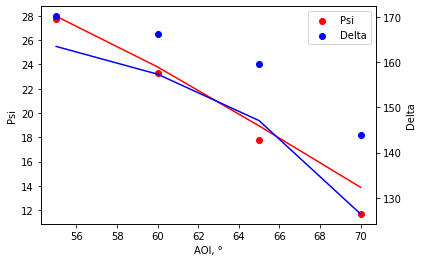

In [42]:
fig, ax = plt.subplots()
axt = ax.twinx()

aois = np.linspace(50, 75, 100)

for dat in data.unique_wavelength_data():
    wavelength, aois, psi_d, delta_d = dat
    wavelength_aois = np.c_[np.ones_like(aois) * wavelength, aois]
    
    psi, delta = model(wavelength_aois)
    ax.plot(aois, psi, color='r')
    p = ax.scatter(data.aoi, data.psi, color='r')

    axt.plot(aois, delta, color='b')
    d = axt.scatter(data.aoi, data.delta, color='b')

ax.legend(handles=[p,d], labels=['Psi', 'Delta'])
ax.set(ylabel='Psi', xlabel='AOI, °')
axt.set(ylabel='Delta')
plt.show()

### Creating an objective

We will now create an objective. The `Objective` obeject is made from combining the model and the data, and is used to calculate statistics during the fitting process.

In [43]:
objective = ObjectiveSE(model, data)

### Fitting the data

The optimisation of our `Objective` is performed by *refnx*'s `CurveFitter`. Data can be fit using a local optimisation such as `least_squares`, or a more global optimisation technique such as `differential_evolution`. For more infomation on the available fitting methods, see [*refnx*](https://refnx.readthedocs.io/en/latest/refnx.analysis.html#refnx.analysis.CurveFitter.fit).

In [44]:
fitter = CurveFitter(objective)
fitter.fit(method='least_squares');

### Optimised model and data post fit

We can now view our optimised objective, including our fit parameters.

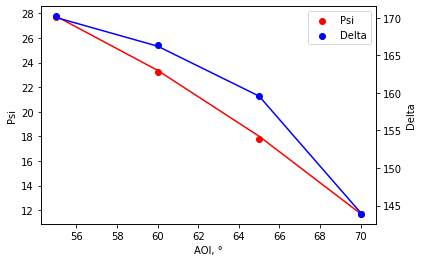

In [45]:
fig, ax = plt.subplots()
axt = ax.twinx()

aois = np.linspace(50,75,100)

for dat in data.unique_wavelength_data():
    wavelength, aois, psi_d, delta_d = dat
    wavelength_aois = np.c_[np.ones_like(aois) * wavelength, aois]
    
    psi, delta = model(wavelength_aois)

    ax.plot(aois, psi, color='r')
    p = ax.scatter(data.aoi, data.psi, color='r')

    axt.plot(aois, delta, color='b')
    d = axt.scatter(data.aoi, data.delta, color='b')

ax.legend(handles=[p,d], labels=['Psi', 'Delta'])
ax.set(ylabel='Psi', xlabel='AOI, °')
axt.set(ylabel='Delta')
plt.show()

In [48]:
for i, x in enumerate(objective.model.parameters):
    print(x)
# print(objective)

________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'delta offset' , value=0 (fixed)  , bounds=[-10.0, 10.0]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=inf (fixed)  , bounds=[-inf, inf]>
<Parameter:  ' - rough'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:' - volfrac solvent', value=0 (fixed)  , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:    'PNIPAM'    
<Parameter:  ' - thick'   , value=130.05  +/- 329 , bounds=[100.0, 500.0]>
<Parameter:  ' - rough'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:' - volfrac solvent', value=0 (fixed)  , bounds=[0.0, 1.0]>
___________________________________________________________________

We can also view the resultant refractive index profile of the interface as well. N.B. as this section of the codebase belongs to *refnx*, we refer to the refractive index profile as the `sld_profile`.

In [ ]:
structure.reverse_structure = True
plt.plot(*structure.sld_profile())

### Saving the objective

If you would like to save the `Objective` or model to a file, this is best done through serialisationo to a Python pickle.

In [ ]:
import pickle
pickle.dump(objective, open('my_objective.pkl', 'wb'))

You can then simply reload your objective.

In [ ]:
objective = pickle.load(open('my_objective.pkl', 'rb'))